# OC IML Projet 5 : Catégorisez automatiquement des questions

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique
développez *un système de suggestion de tag* pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.


Ce notebook contient : 
- Exploration des données



## import

In [142]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import re

from sklearn import metrics

import scipy.stats as st

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from collections import defaultdict

[nltk_data] Downloading package punkt to /Users/gregory/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregory/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Definitions

In [5]:
# source paths
PATH_SOURCE_QUESTIONS = '../../data/QueryResults.csv' 

## Useful functions

In [8]:
def display_missing(df):
    '''
    Display dataFrame missing values : barplots & numbers
    ouput : dataFrame containing missing numbers
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing

## Loading

In [6]:
# loading each sources
df_quest = pd.read_csv(PATH_SOURCE_QUESTIONS, sep=',')

### Questions

In [7]:
df_quest.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
0,50000002,2,NaN,49999948.0,2018-04-24 11:00:00,NaN,2,NaN,<p>You need to have a pointer to the <code>ma...,1983495.0,NaN,1983495.0,NaN,2018-04-24 12:14:36,2018-04-24 12:14:36,NaN,NaN,NaN,4,NaN,NaN,NaN
1,50000003,2,NaN,49995279.0,2018-04-24 11:00:00,NaN,1,NaN,<p>The old state is discarded. If you want to ...,506441.0,NaN,NaN,NaN,NaN,2018-04-24 11:00:00,NaN,NaN,NaN,3,NaN,NaN,NaN
2,50000004,2,NaN,49999911.0,2018-04-24 11:00:01,NaN,0,NaN,<p>If you are trying to achieve the above outp...,6155965.0,NaN,NaN,NaN,NaN,2018-04-24 11:00:01,NaN,NaN,NaN,6,NaN,NaN,NaN
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,NaN,2018-04-24 11:03:32,2018-04-24 13:15:50,How to insert an entry to a table only if it d...,<c#><sql><sql-server>,3.0,0,NaN,NaN,NaN
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,NaN,NaN,2018-05-01 13:24:04,System DMV's missing from SQL Server 2017 mast...,<sql-server><sql-server-data-tools>,1.0,2,NaN,NaN,NaN


In [36]:
df_quest["Id"].nunique()

50000

,nb_missing,ratio
Id,0,0.000
PostTypeId,0,0.000
LastActivityDate,0,0.000
CommentCount,0,0.000
CreationDate,0,0.000
Score,0,0.000
Body,24,0.048
OwnerUserId,508,1.016
ParentId,21280,42.560
ViewCount,28792,57.584


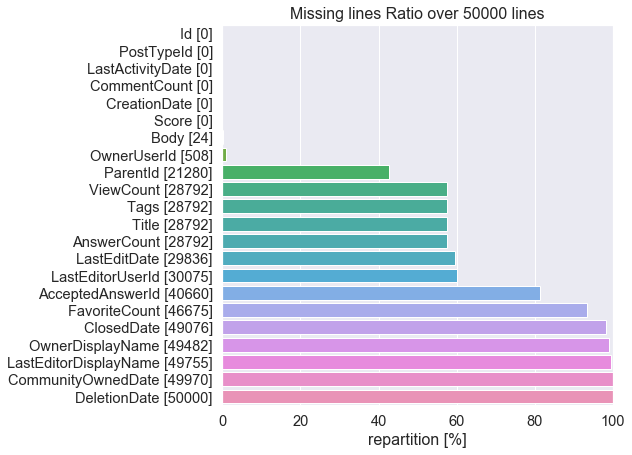

In [9]:
display_missing(df_quest)

In [13]:
test = "Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !"

nltk.word_tokenize(test)

['Bonjour',
 ',',
 'je',
 'suis',
 'un',
 'texte',
 "d'exemple",
 'pour',
 'le',
 'cours',
 "d'Openclassrooms",
 '.',
 'Soyez',
 'attentifs',
 'à',
 'ce',
 'cours',
 '!']

In [28]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
tokens_test = tokenizer.tokenize("Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !")
tokens_test

['Bonjour',
 'je',
 'suis',
 'un',
 'texte',
 'd',
 'exemple',
 'pour',
 'le',
 'cours',
 'd',
 'Openclassrooms',
 'Soyez',
 'attentifs',
 'à',
 'ce',
 'cours']

In [30]:
set(tokens_test)

{'Bonjour',
 'Openclassrooms',
 'Soyez',
 'attentifs',
 'ce',
 'cours',
 'd',
 'exemple',
 'je',
 'le',
 'pour',
 'suis',
 'texte',
 'un',
 'à'}

In [29]:
type(tokens_test)

list

In [32]:
'''
# test du marche pas du au format

def my_tokenizer(text_str):
    
    if text_str == np.nan :
        return np.nan
    
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text_str)
    
df_quest["body_tokens"] = df_quest["Body"].apply(my_tokenizer)
df_quest.head()
'''

'\n# test du marche pas du au format\n\ndef my_tokenizer(text_str):\n    \n    if text_str == np.nan :\n        return np.nan\n    \n    tokenizer = nltk.RegexpTokenizer(r\'\\w+\')\n    return tokenizer.tokenize(text_str)\n    \ndf_quest["body_tokens"] = df_quest["Body"].apply(my_tokenizer)\ndf_quest.head()\n'

In [56]:

#questions = defaultdict(set)

questions = df_quest.filter(items=["Body"]).to_dict()
questions = questions["Body"]
print('{} questions'.format(len(questions)))

50000 questions


In [59]:
questions[0]

'<p>You need to have a  pointer to the <code>malloc()</code>ed area, you can <em>mimic</em> <code>malloc()</code>\'s behavior like this</p>\n\n<pre><code>int *gener_random(int size) {\n    int *values = malloc(size * sizeof(values));\n    for(int i = 0; i &lt; size; i++)\n        values[i] = rand(); \n    return values;\n}\n</code></pre>\n\n<p>The reason your code doesn\'t work is largely discussed on <a href="https://stackoverflow.com">Stack Overflow</a>, your <code>int *value</code> parameter is local to <code>gener_random()</code> and making it point to the return value of <code>malloc()</code> does not change your <code>main()</code>\'s <code>values</code>, it does only make the local pointer point to new memory and you lose the reference when the function returns.</p>\n\n<p>Two acceptable techniques exist,</p>\n\n<ol>\n<li><p>Return the locally declared pointer after you check that it was succesfuly allocated.</p>\n\n<pre><code>int *gener_random(int size) {\n    int *values = mall

In [106]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

def freq_stats_corpora():
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        #print(id_curr)
        try:
            corpora[id_curr] += tokenizer.tokenize(questions_curr.lower())
        except:
            print('Question {} : Error body empty'.format(id_curr))
            

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

# Récupération des comptages
freq, stats, corpora = freq_stats_corpora()
df_stats = pd.DataFrame.from_dict(stats, orient='index')

# Affichage des fréquences
#df.sort(columns='total', ascending=False)
#df = df.sort_values(by=['total'], ascending=False)
#df.head(50).plot(kind='bar', color="#f56900", title='Top 50 Rappeurs par nombre de mots')

Qestion 654 : Error body empty
Qestion 8466 : Error body empty
Qestion 9964 : Error body empty
Qestion 9965 : Error body empty
Qestion 11670 : Error body empty
Qestion 11671 : Error body empty
Qestion 18756 : Error body empty
Qestion 19659 : Error body empty
Qestion 26623 : Error body empty
Qestion 27991 : Error body empty
Qestion 27992 : Error body empty
Qestion 28372 : Error body empty
Qestion 28373 : Error body empty
Qestion 29300 : Error body empty
Qestion 31667 : Error body empty
Qestion 31668 : Error body empty
Qestion 31763 : Error body empty
Qestion 31764 : Error body empty
Qestion 39923 : Error body empty
Qestion 40623 : Error body empty
Qestion 40641 : Error body empty
Qestion 42311 : Error body empty
Qestion 42312 : Error body empty
Qestion 48402 : Error body empty


In [117]:
df_stats.head()

,total,unique
0,264,95
1,123,73
2,21,20
3,68,42
4,411,192


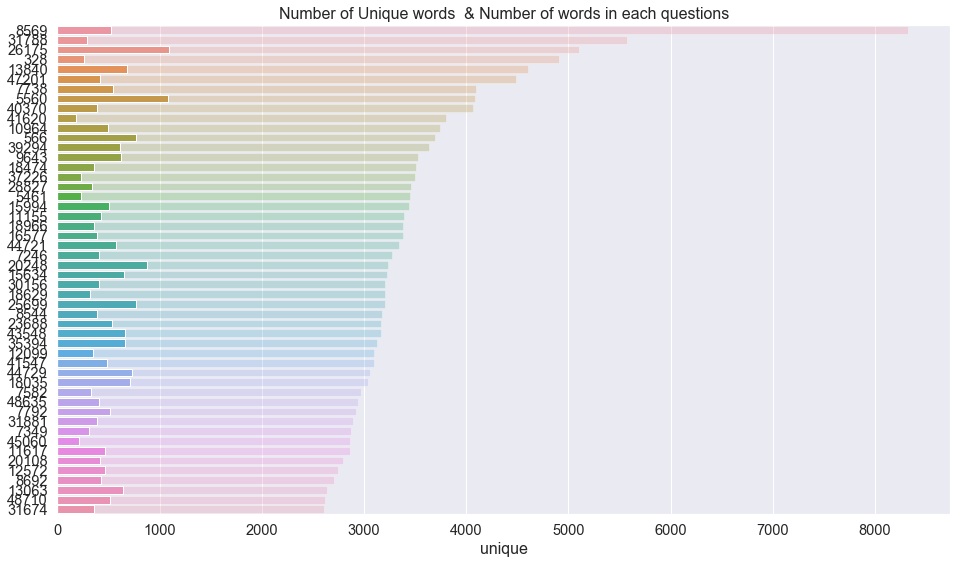

In [119]:
fig = plt.figure(figsize=(16, 9))
plt.title("Number of Unique words  & Number of words in each questions")
df_plot = df_stats.sort_values(by=['total'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [110]:
df_plot.T

,8569,31788,26175,328,13840,47201,7738,5560,40370,41620,10964,566,...,48635,7792,31881,7349,45060,11617,20108,12572,8692,13063,48710,31674
total,8318,5572,5103,4911,4603,4484,4094,4087,4067,3798,3741,3698,...,2941,2919,2891,2876,2867,2863,2794,2749,2707,2636,2614,2613
unique,526,286,1091,257,682,413,543,1085,392,183,491,765,...,406,514,393,308,212,464,422,467,428,644,519,361


In [111]:
len(df_quest.loc[8569].Body)

32096

In [112]:
len(df_quest.loc[43836].Body) 

48

In [113]:
df_quest.loc[43836].Body

'<p>self.scrollToRow(at: indexPath.last ...)</p>\n'

In [114]:
tokenizer.tokenize(df_quest.loc[43836].Body)

['p', 'self', 'scrollToRow', 'at', 'indexPath', 'last', 'p']

In [115]:
'tEst test'.encode('utf-8').decode('utf-8')

'tEst test'

In [120]:
# Premièrement, on récupère la fréquence totale de chaque mot sur tout le corpus d'artistes
freq_totale = nltk.Counter()
for k, v in questions.items():
    freq_totale += freq[k]



NameError: name 'freq2' is not defined

In [145]:
# Deuxièmement on décide manière un peu arbitraire du nombre de mots les plus 
# fréquents à supprimer. On pourrait afficher un graphe d'évolution du nombre 
# de mots pour se rendre compte et avoir une meilleure heuristique. 
# On créé notre set de stopwords final qui cumule ainsi les 100 mots les plus 
# fréquents du corpus ainsi que l'ensemble de stopwords par défaut présent 
# dans la librairie NLTK
most_freq = freq_totale.most_common(100)
sw = set()
for tuple_freq in most_freq:
    sw.add(tuple_freq[0])
    
sw.update(tuple(nltk.corpus.stopwords.words('english')))
sw

{'0',
 '1',
 '2',
 '3',
 '4',
 '5',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'amp',
 'an',
 'and',
 'android',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'c',
 'can',
 'class',
 'code',
 'com',
 'couldn',
 "couldn't",
 'd',
 'data',
 'did',
 'didn',
 "didn't",
 'div',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'em',
 'error',
 'false',
 'few',
 'file',
 'for',
 'from',
 'function',
 'further',
 'get',
 'gt',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'href',
 'html',
 'https',
 'i',
 'id',
 'if',
 'import',
 'in',
 'int',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'java',
 'js',
 'just',
 'li',
 'like',
 'll',
 'lt',
 'm',
 'ma',
 

In [146]:
def freq_stats_corpora2():
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        #print(id_curr)
        try:
            tokens = tokenizer.tokenize(questions_curr.lower())
            corpora[id_curr] += [w for w in tokens if not w in list(sw)]
        except:
            print('Question {} : Error body empty'.format(id_curr))
            

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

freq2, stats2, corpora2 = freq_stats_corpora2()

Question 654 : Error body empty
Question 8466 : Error body empty
Question 9964 : Error body empty
Question 9965 : Error body empty
Question 11670 : Error body empty
Question 11671 : Error body empty
Question 18756 : Error body empty
Question 19659 : Error body empty
Question 26623 : Error body empty
Question 27991 : Error body empty
Question 27992 : Error body empty
Question 28372 : Error body empty
Question 28373 : Error body empty
Question 29300 : Error body empty
Question 31667 : Error body empty
Question 31668 : Error body empty
Question 31763 : Error body empty
Question 31764 : Error body empty
Question 39923 : Error body empty
Question 40623 : Error body empty
Question 40641 : Error body empty
Question 42311 : Error body empty
Question 42312 : Error body empty
Question 48402 : Error body empty


In [148]:
df_stats2 = pd.DataFrame.from_dict(stats2, orient='index')
df_stats2.head()

,total,unique
0,101,50
1,56,40
2,8,8
3,31,22
4,202,120


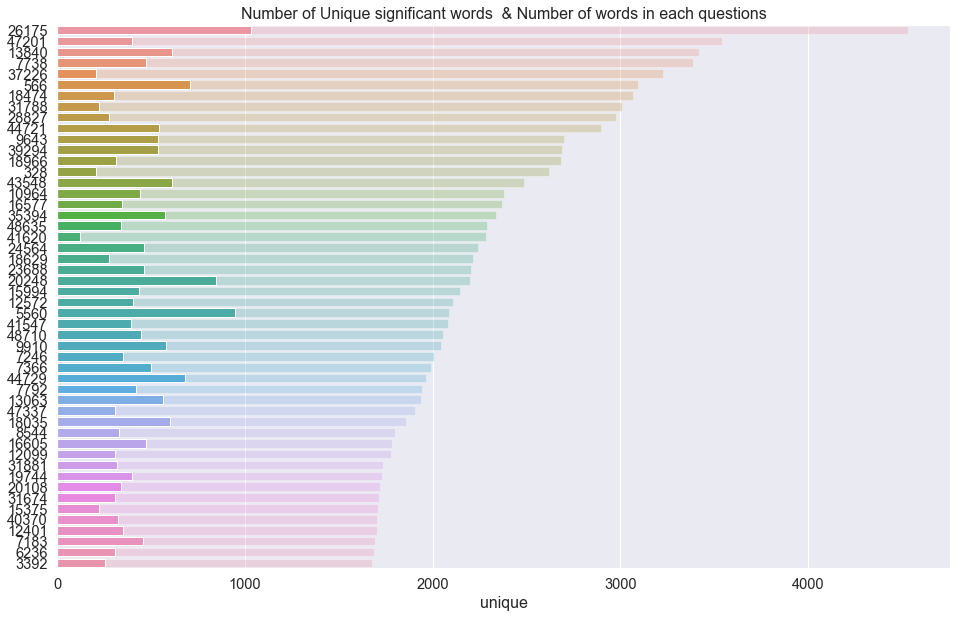

In [150]:
fig = plt.figure(figsize=(16, 10))
plt.title("Number of Unique significant words  & Number of words in each questions")
df_plot = df_stats2.sort_values(by=['total'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [151]:
df_plot.head()

,total,unique
26175,4531,1033
47201,3540,396
13840,3418,610
7738,3386,475
37226,3229,208


In [153]:
df_stats2.loc[26175]

total     4531
unique    1033
Name: 26175, dtype: int64

In [154]:
df_stats.loc[26175]

total     5103
unique    1091
Name: 26175, dtype: int64